<a href="https://colab.research.google.com/github/JonSolow/foodid/blob/master/notebooks/jss_foodid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
Question - how do we know what type of food is shown in an image?

Answers - 
1.   Memory - We have seen the food before
2.   Perspective - we know how the food is served and what other items would surround that food in a picture (ex: bowls with soup or french fries with hamburgers)

Bigger Question - How can we teach a computer/robot to identify food?

We can potentially use this information to make robot food preparers or food service bots.  It can also be used to scrape yelp photo reviews and identify restaurants by cuisine or particular dish searches.


# Mount Drive for Saving

IMPORTANT - If you run on google colab, your environment will completely reset every 12 hours (when using a GPU instance).

This is why it is useful to mount your google drive for loading and saving.  We can save checkpoint files from our model training to pick up from where we left off if we want to train for more than 12 hours.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Download Data

Data is download from the source provided at:

Food-101 – Mining Discriminative Components with Random Forests

Lukas Bossard, Matthieu Guillaumin, Luc Van Gool

https://www.vision.ee.ethz.ch/datasets_extra/food-101/

In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2019-07-30 22:22:50--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-07-30 22:22:51--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  26.5MB/s    in 3m 10s  

2019-07-30 22:26:01 (25.1 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



Extract the files

In [0]:
!tar xzf food-101.tar.gz


## Code Imports

In [0]:
# Add repo path to allow for importing custom functions while working on google colab
import sys
repo_path = './drive/My Drive/FoodID'
sys.path.append(repo_path)

In [0]:
from functions import *

Using TensorFlow backend.


# Defining Image Generators

## Pre-defined Train Test Split of Images in Dataset
The dataset authors provide a list in json format of the locations of the training and test images.

In [0]:
img_path = './food-101/images/'
meta_path = './food-101/meta'

df_train = file_path_dataframe(os.path.join(meta_path, 'train.json'))
df_test = file_path_dataframe(os.path.join(meta_path, 'test.json'))

# Check that there are 75,750 training images and 25,250 testing images
print(df_train.shape, df_test.shape)

(75750, 2) (25250, 2)


In [0]:
# Take a peak to make sure the dataframes are correct
df_train.head()

,class,filename
0,churros,churros/1004234.jpg
1,churros,churros/1013460.jpg
2,churros,churros/1016791.jpg
3,churros,churros/102100.jpg
4,churros,churros/1025494.jpg


In [0]:
# Check to see that each class in the training has 750 instances and each class in testing has #250

train_class = df_train['class'].value_counts()
print(train_class.min(), train_class.max())

test_class = df_test['class'].value_counts()
print(test_class.min(), test_class.max())


750 750
250 250


## ImageDataGenerator
From the newly created dataframes, we can create a generator to provide our model with images.  The generator is a set of rules for how to load the images.

ImageDataGenerator is a great keras tool that allows us to define a pipeline for importing images (either based on a dataframe or a directory structure) without having to import and manipulate all of the images at one time.

It also allows us to manipulate the images.  In this case, we are applying random shifts of 10% of the image width and height and rotating images by up to 30 degrees in the training set.  This allows the model to become smarter by giving it images that differ in more ways. 

We also apply a rescaling by dividing the values of the image by 255 (2^8 - 1).  This produces values that range from 0 to 1.  This rescaling helps with the model and also puts the data in a format that our graphing function (imshow) can use.

In [0]:
# create image generator and generator training and test

train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1, 
                                     rotation_range=30, 
                                     horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

data_train = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory='./food-101/images/', 
    x_col= 'filename', 
    y_col='class', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=101, 
    shuffle=True, 
    seed=42, 
    )


data_test = test_datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory='./food-101/images/', 
    x_col='filename', 
    y_col='class', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=101, 
    shuffle=True, 
    seed=42, 
    )


Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


## Class Labels

The class labels are provided for us in the labels.txt file.  There are several options for bringing in a text file, but numpy provides a relatively straightforward solution.  However, we must specify that the data type is a string and that the items are delimited by a new line.

In [0]:
labels = np.loadtxt(os.path.join(meta_path, 'labels.txt'), dtype=str, delimiter='\n')

# Take a gander at the beginning and end of the list.
print('{} different classes'.format(len(labels)))
print(labels[:10])
print('...')
print(labels[-10:])

101 different classes
['Apple pie' 'Baby back ribs' 'Baklava' 'Beef carpaccio' 'Beef tartare'
 'Beet salad' 'Beignets' 'Bibimbap' 'Bread pudding' 'Breakfast burrito']
...
['Spaghetti carbonara' 'Spring rolls' 'Steak' 'Strawberry shortcake'
 'Sushi' 'Tacos' 'Takoyaki' 'Tiramisu' 'Tuna tartare' 'Waffles']


# Random Forest Classifier

We'll take a more naive model (RandomForestClassifier) as a baseline.  This model will be very bad without performing more complicated data extractions on the images.

The model doesn't perform well because it will treat the image as an array of 150,528 numbers (224x224x3).  The meaning of the image gets lost when each pixel's amount of red, green, and blue are the only information provided.

In [0]:
train_batches = 8
test_batches = 2

rf_train_images = []
rf_train_labels = []

rf_test_images = []
rf_test_labels = []

for _ in range(train_batches):
  tmp_img, tmp_lbl = next(data_train)
  rf_train_images.extend(tmp_img)
  rf_train_labels.extend(tmp_lbl)

for _ in range(test_batches):
  tmp_img, tmp_lbl = next(data_test)
  rf_test_images.extend(tmp_img)
  rf_test_labels.extend(tmp_lbl)

rf_train_images = [x.flatten() for x in rf_train_images]
rf_test_images = [x.flatten() for x in rf_test_images]


In [0]:
rf_train_labels = np.argmax(rf_train_labels, axis=1)
rf_test_labels = np.argmax(rf_test_labels, axis=1)

In [0]:
# Define the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(rf_train_images, rf_train_labels)

# Score the model based on the testing data
rf_model.score(rf_test_images, rf_test_labels)

0.024752475247524754

As we can see, this model is not great.  Its accuracy of about 2.4% is only 2.4 times better than a completely random guess.

In [0]:
# clear memory before proceeding
rf_train_images = None
rf_train_labels = None

rf_test_images = None
rf_test_labels = None

# CNN Convultional Neural Network

## Model Layers

The first step is to set up the actual framework of the neural network.  This network includes 5 convolutional layers.

I based this model's structure on a model produced by Adrian Rosebrock to classify images of Pokemon:
https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/


In [0]:
# Define the CNN model
cnn = Sequential()
inputShape = (224, 224, 3)
chanDim = -1
classes=101

# Convultional layer takes 32 different filters of size 3x3 and scans 
# over each image which is made up of 224x224 pixels by 3 channels (RGB)
cnn.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
# BatchNormalization avoids shifts in the distribution of the data by normalizing.
# It also makes training more efficient.
cnn.add(BatchNormalization(axis=chanDim))
# MaxPooling cuts the image size down by removing the outside of the pool size.
# In this case, the pool size is 3x3 and the image is reduced to 1/3 of original.
cnn.add(MaxPooling2D(pool_size=(3, 3)))
# Dropout layers help to avoid overfitting the model to the training data
# by randomly dropping out a percentage of the connections between layers.
cnn.add(Dropout(rate=0.25))

# Another convolution without the MaxPooling reduction and Dropout
cnn.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
cnn.add(BatchNormalization(axis=chanDim))

# Another convolution similar to the first
cnn.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
cnn.add(BatchNormalization(axis=chanDim))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(rate=0.25))

# Another convolution similar to the second
cnn.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
cnn.add(BatchNormalization(axis=chanDim))

# Another convolution similar to the first
cnn.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
cnn.add(BatchNormalization(axis=chanDim))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(rate=0.25))

# After the 5 convolutions, we Flatten the data (turn into one long array)
# The flattened data goes through a densely connected layer
# and then one more BatchNormalization and Dropout
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(rate=0.5))

# The final layer is a Dense layer with neurons equal to the number of classes
# The activation is softmax, which provides relative probabilities 
cnn.add(Dense(classes, activation='softmax'))


W0730 22:30:04.038949 140070032140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 22:30:04.086108 140070032140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 22:30:04.093362 140070032140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 22:30:04.134551 140070032140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0730 22:30:04.136026 1400700321

## Model Optimizer, Loss Function, and Callbacks

The loss function and optimizer work together to adjust the weights (parameters) of the model between each batch.  The goal of the process is to minimize the loss function.

The metrics (accuracy, top-3 accuracy, and top-10 accuracy) are just gauges of how well we are doing.  They do not actually influence the results of the model, but we can use them to determine whether our model is getting better in each epoch.

In [0]:
# Set initial learning rate for optimizer
INIT_LR = 1e-2
opt = SGD(lr=INIT_LR, momentum=0.9)

def schedule(epoch):
  if epoch<100:
    return 1e-2
  elif epoch<200:
    return 5e-3
  else:
    return 5e-4

learningrate_scheduler = LearningRateScheduler(schedule)

# Create top-2 through top-10 accuracy metrics
top2_acc = functools.partial(top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

top4_acc = functools.partial(top_k_categorical_accuracy, k=4)
top4_acc.__name__ = 'top4_acc'

top5_acc = functools.partial(top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

top6_acc = functools.partial(top_k_categorical_accuracy, k=6)
top6_acc.__name__ = 'top6_acc'

top7_acc = functools.partial(top_k_categorical_accuracy, k=7)
top7_acc.__name__ = 'top7_acc'

top8_acc = functools.partial(top_k_categorical_accuracy, k=8)
top8_acc.__name__ = 'top8_acc'

top9_acc = functools.partial(top_k_categorical_accuracy, k=9)
top9_acc.__name__ = 'top9_acc'

top10_acc = functools.partial(top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

# Compile model with the loss, optimizer, and metrics
cnn.compile(loss="categorical_crossentropy", optimizer=opt, 
            metrics=["accuracy", top2_acc, top3_acc, top4_acc, top5_acc, top6_acc, top7_acc, top8_acc, top9_acc, top10_acc])

# create checkpoint file, verbose display of saving, keep best checkpoint 
checkpoint = ModelCheckpoint(filepath='./drive/My Drive/FoodModels/modelcnn_demo.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
csv_logger = CSVLogger('./drive/My Drive/FoodModels/modelcnn_demo.log')

The summary method of the model shows the structure, shapes, and parameters of the model.

I like to take a look before fitting to make sure everything is in order.

In [0]:
print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 74, 74, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
__________

We train the model using the fit generator method.  This cool method takes the image data generators that we produced earlier and processes small batches of data.  This prevents the CPU and GPU from getting overloaded and crashing.

Because I used google colab, there were several periods of starting and stopping.  I ended up running for approximately 200 epochs, but had a few times when the environment reset and I had to pick up from a saved checkpoint. (This is why checkpoints are critical!)

In [0]:
start_from = 0
cnn_history = cnn.fit_generator(data_train, 
                                steps_per_epoch=200,
                                epochs=200, 
                                validation_data=data_test, 
                                validation_steps=250,
                                verbose=1,
                                callbacks=[learningrate_scheduler, csv_logger, checkpoint], 
                                initial_epoch=start_from)


I can load the checkpoint's saved weights using the load_weights method of the model.

In [0]:
# Load trained model weights
cnn.load_weights(filepath='./drive/My Drive/FoodModels/modelcnn_20190722.hdf5')

Let's see how the model does on all of the testing data.

In [0]:
%%time
cnn_test_results = cnn.evaluate_generator(data_test, steps=250)

CPU times: user 2min 9s, sys: 11.9 s, total: 2min 21s
Wall time: 2min 4s


In [0]:
pd.DataFrame(enumerate(cnn_test_results[1:], 1), columns=['k', 'top-k_accuracy']).set_index('k')

,top-k_accuracy
k,
1,0.530455
2,0.655881
3,0.725941
4,0.768158
5,0.803723
6,0.828832
7,0.848158
8,0.863802
9,0.878297


Not too shabby for a model that was trained from scratch.  We got 53% accuracy on the first guess, 72% accuracy on top 3 guesses, and 89% accuracy on top 10 guesses.

This model would need some improvement to be used for food service, but for the purpose of entertainment on a website, it will do quite well.

In [0]:
%%time
all_test_pred = []
all_test_actual = []

for i in range(250):
  sample_test_data, sample_test_labels = next(data_test)
  sample_pred = cnn.predict_classes(sample_test_data)
  all_test_pred.extend(sample_pred)
  all_test_actual.extend(sample_test_labels.argmax(axis=1))
  

CPU times: user 2min 2s, sys: 7.33 s, total: 2min 9s
Wall time: 2min 44s


A classification report tells us how well the model can predict each class.  

The precision is a measure of how many of the guesses of that class were correct.

The recall is a measure of what percentage of the actual members of a class were predicted correctly by the model.

f1-score is a harmonic mean of the other two metrics.

In [0]:
print(classification_report(all_test_actual, all_test_pred, target_names=labels))

                         precision    recall  f1-score   support

              Apple pie       0.34      0.23      0.27       250
         Baby back ribs       0.59      0.43      0.50       250
                Baklava       0.44      0.67      0.53       250
         Beef carpaccio       0.69      0.70      0.70       250
           Beef tartare       0.46      0.57      0.51       250
             Beet salad       0.69      0.43      0.53       250
               Beignets       0.31      0.73      0.44       250
               Bibimbap       0.85      0.72      0.78       250
          Bread pudding       0.44      0.32      0.37       250
      Breakfast burrito       0.47      0.12      0.19       250
             Bruschetta       0.44      0.45      0.45       250
           Caesar salad       0.53      0.81      0.64       250
                Cannoli       0.52      0.31      0.39       250
          Caprese salad       0.59      0.59      0.59       250
            Carrot cake 

A confusion matrix shows a comparison of the actual versus predicted labels.  We can see how wrong the wrong guesses were.  

For instance, when we get chocolate cake wrong, are we getting a lot of chocolate mousse guesses? (Note: this happens to be the case, which makes sense.)

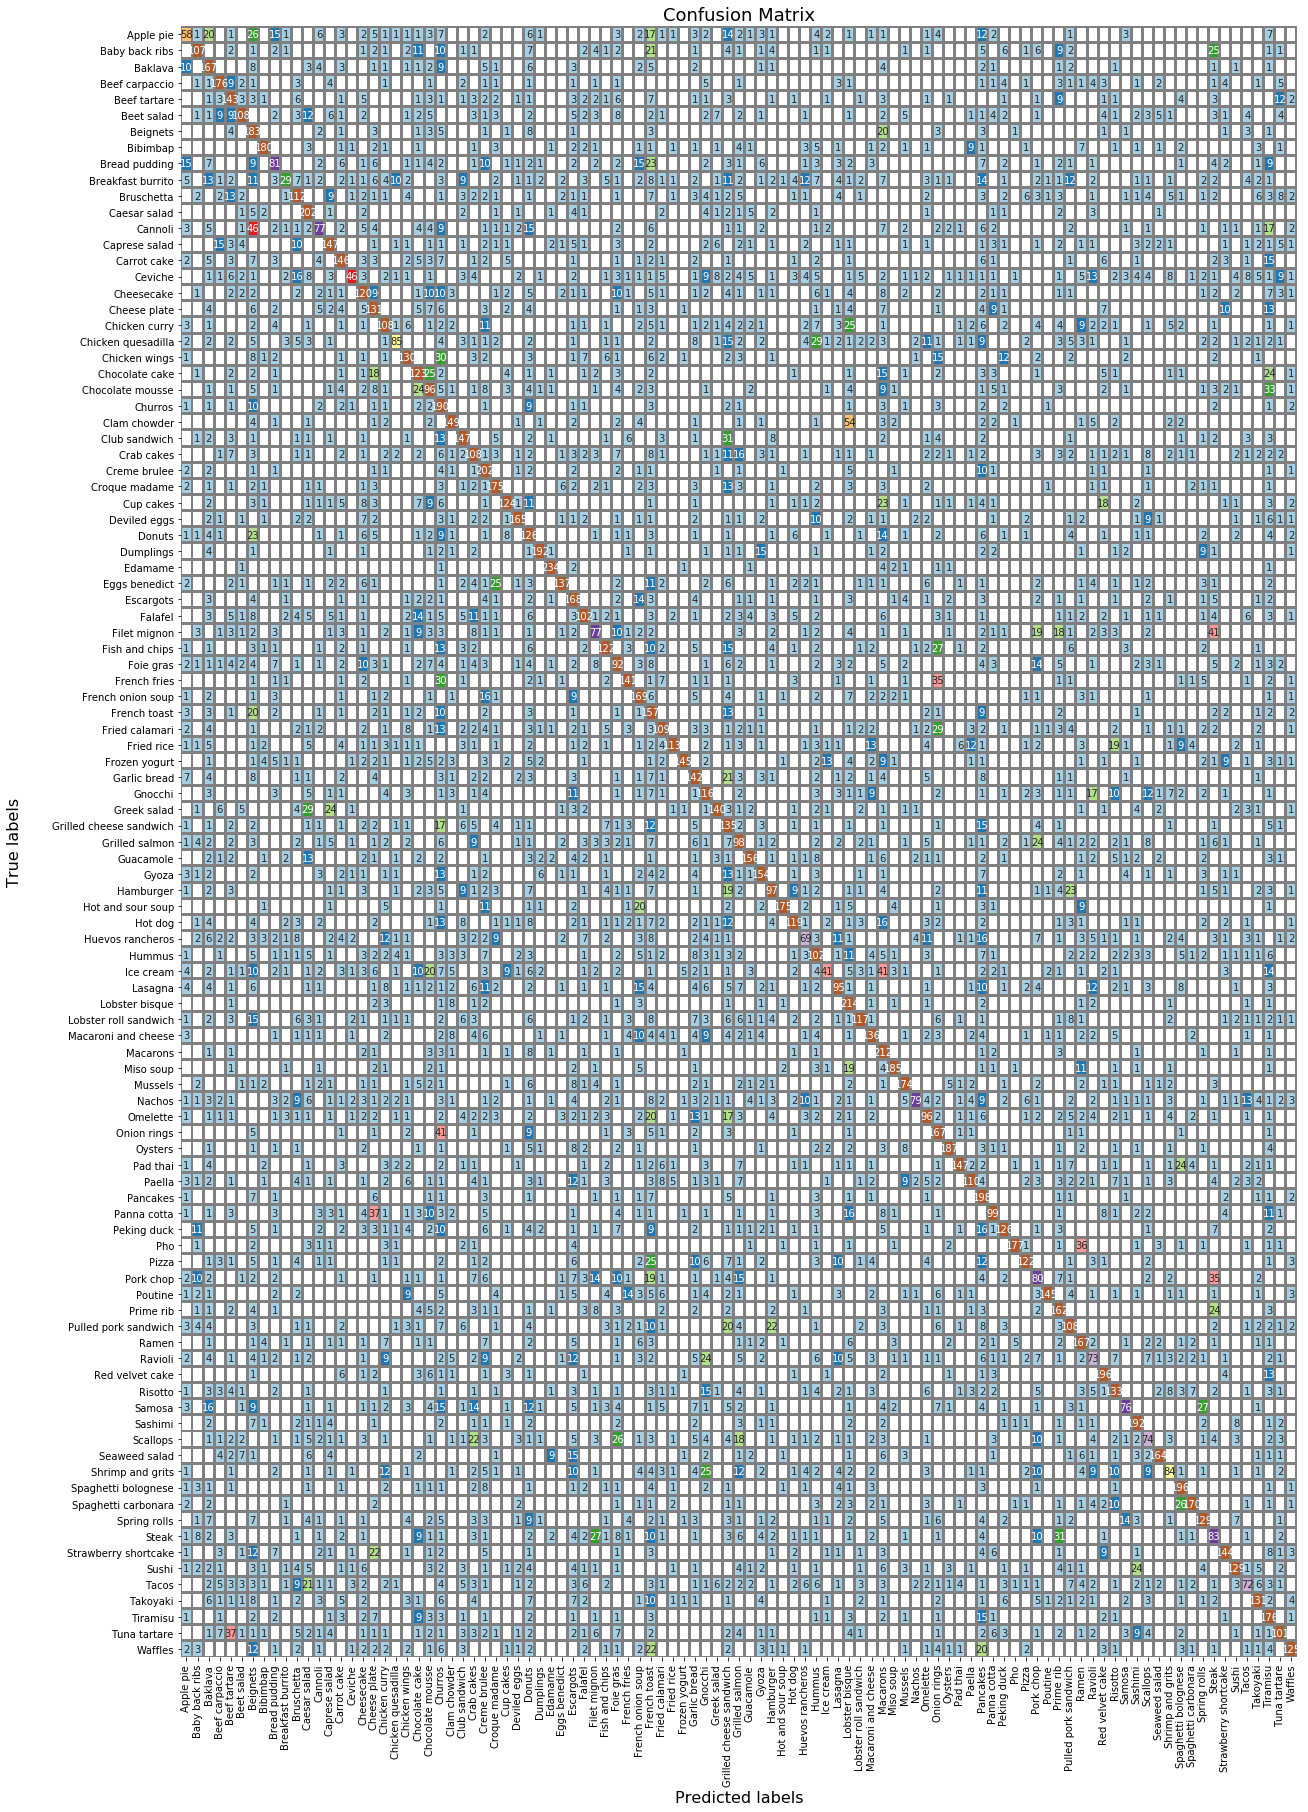

In [0]:
plot_confusion_matrix(all_test_actual, all_test_pred,  class_labels = labels, figsize=(20,30))

# Next steps

I have attempted to use the pre-trained Inception_v3 model, but have not yet achieved comprable results.  There are some deeper networks that may outperform this model that I will try in the future.

Additionally, there are more image manipulation techniques that may provide better accuracy.

The next step after the model is finished is to apply it in a web app. I have done so using Django and Heroku at the website below:

http://grubguesser.herokuapp.com/